# Exercise 4 — Linear Regression on Perturbed Sine (Feature Engineering) — OLS + sklearn

This notebook solves Exercise 4: **Fit Linear Regression to a perturbed sine dataset by adding appropriate features** (polynomial and/or other transformations), then evaluate and conclude.

We will:
1) Load & preview data (or synthesize if missing)  
2) Split into features (X) and target (Y)  
3) Establish a **baseline** linear model  
4) Engineer **polynomial**, **trigonometric**, and **segment** features  
5) Compare models via **sklearn (prediction)** and **statsmodels OLS (inference)**  
6) Inspect **residual diagnostics** and the **full OLS summary** for the best model  
7) Summarize **takeaways** for students

## Cell 1 — Imports

In [1]:
# PURPOSE:
# - Import libraries for data handling, modeling (sklearn + statsmodels), feature engineering,
#   metrics, and plotting. We'll use only matplotlib for plots to keep dependencies simple.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cell 2 — Load dataset and preview

In [3]:
# PURPOSE:
# - Load 'sine-segment-perturbed.csv' if present.
# - If missing, synthesize a sine-with-segments dataset with noise so the notebook still runs.
# - Preview the first few rows so students see the structure.
#
# COLUMN INFERENCE RULE:
# - If a column named 'Y' or 'y' exists, we treat it as target, the rest as features.
# - Else, if there are exactly 2 columns, we assume first = X, second = Y.
# - Else, we assume the last column is Y and all others are features.

csv_path = Path("/content/drive/MyDrive/IIT Bombay/sine-segment-perturbed.csv")
if csv_path.exists():
    df = pd.read_csv(csv_path)
    print("Loaded:", csv_path.name)
else:
    # Synthetic fallback: a noisy, piecewise-perturbed sine curve
    rng = np.random.default_rng(42)
    n = 400
    x = np.linspace(0, 6*np.pi, n)
    # perturb segments with different offsets/amps
    y = np.sin(x) + 0.4*(x>2*np.pi) - 0.3*(x>4*np.pi) + 0.2*np.sin(3*x) + rng.normal(0, 0.15, size=n)
    df = pd.DataFrame({"X": x, "Y": y})
    print("NOTE: Using synthetic demo data because 'sine-segment-perturbed.csv' was not found.")

print("Head:")
print(df.head())
print("\nColumns:", list(df.columns))

Loaded: sine-segment-perturbed.csv
Head:
   x         y
0  1 -0.028939
1  2 -0.007751
2  3 -0.117974
3  4 -0.034393
4  5  0.164029

Columns: ['x', 'y']


## Cell 3 — Choose target (Y) and base feature(s) (X)

In [4]:
# PURPOSE:
# - Split the dataframe into X_base (DataFrame of features) and y (Series target)
# - Make minimal assumptions, but keep behavior explicit and printed for students.

cols = list(df.columns)

if "Y" in cols:
    y = df["Y"].copy()
    X_base = df.drop(columns=["Y"]).copy()
elif "y" in cols:
    y = df["y"].copy()
    X_base = df.drop(columns=["y"]).copy()
elif len(cols) == 2:
    y = df.iloc[:, 1].copy()
    X_base = df.iloc[:, [0]].copy()
else:
    y = df.iloc[:, -1].copy()
    X_base = df.iloc[:, :-1].copy()

print("Chosen target column name:", y.name)
print("Feature columns:", list(X_base.columns))
print("Shapes -> X_base:", X_base.shape, "| y:", y.shape)

Chosen target column name: y
Feature columns: ['x']
Shapes -> X_base: (700, 1) | y: (700,)


## Cell 4 — Train/Test split & baseline linear model

In [5]:
# PURPOSE:
# - Split into Train/Test.
# - Fit a simple LinearRegression on raw features as baseline.
# - Report R², MAE, RMSE on Train and Test.

X_train, X_test, y_train, y_test = train_test_split(
    X_base, y, test_size=0.2, random_state=123
)
lin_base = LinearRegression().fit(X_train, y_train)

yhat_tr_base = lin_base.predict(X_train)
yhat_te_base = lin_base.predict(X_test)

def metrics(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} -> R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

print("=== Baseline: Raw Features (sklearn) ===")
metrics("Train", y_train, yhat_tr_base)
metrics("Test ", y_test,  yhat_te_base)

=== Baseline: Raw Features (sklearn) ===
Train -> R²: 0.0305 | MAE: 0.4400 | RMSE: 0.5705
Test  -> R²: 0.0529 | MAE: 0.4541 | RMSE: 0.5773


## Cell 5 — Feature engineering helpers (Polynomial, Trigonometric, Segments)

In [6]:
# PURPOSE:
# - Define helper functions to build polynomial/trigonometric features and simple segment indicators.

def add_polynomial(Xdf, degrees=(2,3,4,5,6)):
    X_out = Xdf.copy()
    for col in Xdf.columns:
        x = Xdf[col].astype(float)
        for d in degrees:
            X_out[f"{col}^{d}"] = x**d
    return X_out

def add_trig(Xdf, harmonics=(1,2,3,4,5)):
    X_out = Xdf.copy()
    for col in Xdf.columns:
        x = Xdf[col].astype(float)
        for k in harmonics:
            X_out[f"sin{k}({col})"] = np.sin(k * x)
            X_out[f"cos{k}({col})"] = np.cos(k * x)
    return X_out

def add_segment_indicators(Xdf, n_bins=3):
    col0 = Xdf.columns[0]
    bins = pd.cut(Xdf[col0], bins=n_bins, labels=False, include_lowest=True)
    seg_df = pd.get_dummies(bins, prefix=f"seg_{col0}", dtype=int)
    return pd.concat([Xdf.reset_index(drop=True), seg_df.reset_index(drop=True)], axis=1)

## Cell 6 — Build candidate design matrices

In [7]:
# PURPOSE:
# - Create candidate designs: Poly, Trig, Poly+Trig, Poly+Trig+Seg, and print shapes.

X_poly          = add_polynomial(X_base, degrees=(2,3,4,5,6))
X_trig          = add_trig(X_base, harmonics=(1,2,3,4,5))
X_poly_trig     = add_trig(add_polynomial(X_base, degrees=(2,3,4,5,6)), harmonics=(1,2,3,4,5))
X_poly_trig_seg = add_segment_indicators(X_poly_trig, n_bins=4)

print("Shapes:")
print("  Base                :", X_base.shape)
print("  Poly                :", X_poly.shape)
print("  Trig                :", X_trig.shape)
print("  Poly + Trig         :", X_poly_trig.shape)
print("  Poly + Trig + Seg   :", X_poly_trig_seg.shape)

Shapes:
  Base                : (700, 1)
  Poly                : (700, 6)
  Trig                : (700, 11)
  Poly + Trig         : (700, 66)
  Poly + Trig + Seg   : (700, 70)


In [8]:
print(X_poly.head())

   x   x^2    x^3    x^4     x^5      x^6
0  1   1.0    1.0    1.0     1.0      1.0
1  2   4.0    8.0   16.0    32.0     64.0
2  3   9.0   27.0   81.0   243.0    729.0
3  4  16.0   64.0  256.0  1024.0   4096.0
4  5  25.0  125.0  625.0  3125.0  15625.0


In [9]:
print(X_trig.head())

   x   sin1(x)   cos1(x)   sin2(x)   cos2(x)   sin3(x)   cos3(x)   sin4(x)  \
0  1  0.841471  0.540302  0.909297 -0.416147  0.141120 -0.989992 -0.756802   
1  2  0.909297 -0.416147 -0.756802 -0.653644 -0.279415  0.960170  0.989358   
2  3  0.141120 -0.989992 -0.279415  0.960170  0.412118 -0.911130 -0.536573   
3  4 -0.756802 -0.653644  0.989358 -0.145500 -0.536573  0.843854 -0.287903   
4  5 -0.958924  0.283662 -0.544021 -0.839072  0.650288 -0.759688  0.912945   

    cos4(x)   sin5(x)   cos5(x)  
0 -0.653644 -0.958924  0.283662  
1 -0.145500 -0.544021 -0.839072  
2  0.843854  0.650288 -0.759688  
3 -0.957659  0.912945  0.408082  
4  0.408082 -0.132352  0.991203  


In [10]:
print(X_poly_trig.head())

   x   x^2    x^3    x^4     x^5      x^6   sin1(x)   cos1(x)   sin2(x)  \
0  1   1.0    1.0    1.0     1.0      1.0  0.841471  0.540302  0.909297   
1  2   4.0    8.0   16.0    32.0     64.0  0.909297 -0.416147 -0.756802   
2  3   9.0   27.0   81.0   243.0    729.0  0.141120 -0.989992 -0.279415   
3  4  16.0   64.0  256.0  1024.0   4096.0 -0.756802 -0.653644  0.989358   
4  5  25.0  125.0  625.0  3125.0  15625.0 -0.958924  0.283662 -0.544021   

    cos2(x)  ...  sin1(x^6)  cos1(x^6)  sin2(x^6)  cos2(x^6)  sin3(x^6)  \
0 -0.416147  ...   0.841471   0.540302   0.909297  -0.416147   0.141120   
1 -0.653644  ...   0.920026   0.391857   0.721038  -0.692896  -0.354938   
2  0.960170  ...   0.149937   0.988696   0.296484   0.955038   0.436328   
3 -0.145500  ...  -0.594642   0.803991  -0.956173   0.292802  -0.942866   
4 -0.839072  ...  -0.958547   0.284934  -0.546245  -0.837625   0.647260   

   cos3(x^6)  sin4(x^6)  cos4(x^6)  sin5(x^6)  cos5(x^6)  
0  -0.989992  -0.756802  -0.653644  -0.

In [11]:
print(X_poly_trig_seg.head())

   x   x^2    x^3    x^4     x^5      x^6   sin1(x)   cos1(x)   sin2(x)  \
0  1   1.0    1.0    1.0     1.0      1.0  0.841471  0.540302  0.909297   
1  2   4.0    8.0   16.0    32.0     64.0  0.909297 -0.416147 -0.756802   
2  3   9.0   27.0   81.0   243.0    729.0  0.141120 -0.989992 -0.279415   
3  4  16.0   64.0  256.0  1024.0   4096.0 -0.756802 -0.653644  0.989358   
4  5  25.0  125.0  625.0  3125.0  15625.0 -0.958924  0.283662 -0.544021   

    cos2(x)  ...  sin3(x^6)  cos3(x^6)  sin4(x^6)  cos4(x^6)  sin5(x^6)  \
0 -0.416147  ...   0.141120  -0.989992  -0.756802  -0.653644  -0.958924   
1 -0.653644  ...  -0.354938  -0.934890  -0.999208  -0.039791  -0.428155   
2  0.960170  ...   0.436328   0.899788   0.566306   0.824195   0.683482   
3 -0.145500  ...  -0.942866  -0.333171  -0.559938  -0.828534   0.042496   
4 -0.839072  ...   0.647260  -0.762269   0.915097   0.403233  -0.125775   

   cos5(x^6)  seg_x_0  seg_x_1  seg_x_2  seg_x_3  
0   0.283662        1        0        0        

## Cell 7 — Train/Test for each design & sklearn quick fits

In [12]:
# PURPOSE:
# - Split each design using the same random_state, fit LinearRegression, and report Train/Test metrics.

def train_eval_sklearn(X, y, name):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=123)
    model = LinearRegression().fit(X_tr, y_tr)
    yhat_tr = model.predict(X_tr)
    yhat_te = model.predict(X_te)
    r2_tr = r2_score(y_tr, yhat_tr); r2_te = r2_score(y_te, yhat_te)
    rmse_tr = np.sqrt(mean_squared_error(y_tr, yhat_tr)); rmse_te = np.sqrt(mean_squared_error(y_te, yhat_te))
    mae_tr = mean_absolute_error(y_tr, yhat_tr); mae_te = mean_absolute_error(y_te, yhat_te)
    print(f"\n=== {name} (sklearn) ===")
    print(f"Train -> R²: {r2_tr:.4f} | MAE: {mae_tr:.4f} | RMSE: {rmse_tr:.4f}")
    print(f"Test  -> R²: {r2_te:.4f} | MAE: {mae_te:.4f} | RMSE: {rmse_te:.4f}")
    return model, (X_tr, X_te, y_tr, y_te, yhat_tr, yhat_te)

sk_base_model, base_data         = train_eval_sklearn(X_base,           y, "Base")
sk_poly_model, poly_data         = train_eval_sklearn(X_poly,           y, "Poly")
sk_trig_model, trig_data         = train_eval_sklearn(X_trig,           y, "Trig")
sk_pt_model,   pt_data           = train_eval_sklearn(X_poly_trig,      y, "Poly + Trig")
sk_pts_model,  pts_data          = train_eval_sklearn(X_poly_trig_seg,  y, "Poly + Trig + Seg")


=== Base (sklearn) ===
Train -> R²: 0.0305 | MAE: 0.4400 | RMSE: 0.5705
Test  -> R²: 0.0529 | MAE: 0.4541 | RMSE: 0.5773

=== Poly (sklearn) ===
Train -> R²: 0.6973 | MAE: 0.2653 | RMSE: 0.3188
Test  -> R²: 0.7466 | MAE: 0.2499 | RMSE: 0.2986

=== Trig (sklearn) ===
Train -> R²: 0.0348 | MAE: 0.4389 | RMSE: 0.5693
Test  -> R²: 0.0250 | MAE: 0.4585 | RMSE: 0.5857

=== Poly + Trig (sklearn) ===
Train -> R²: 0.6973 | MAE: 0.2653 | RMSE: 0.3188
Test  -> R²: 0.7466 | MAE: 0.2499 | RMSE: 0.2986

=== Poly + Trig + Seg (sklearn) ===
Train -> R²: 0.6973 | MAE: 0.2653 | RMSE: 0.3188
Test  -> R²: 0.7466 | MAE: 0.2499 | RMSE: 0.2986


## Cell 8 — Statsmodels OLS comparison & select winner

In [13]:
# PURPOSE:
# - Fit statsmodels OLS on TRAIN sets to obtain Adj R², AIC, BIC for inference-driven comparison.
# - Choose the winner by Adj R² (tie-break by AIC).

def fit_ols_train(X_tr, y_tr):
    X_sm = sm.add_constant(X_tr, has_constant='add')
    return sm.OLS(y_tr, X_sm).fit()

names = ["Base", "Poly", "Trig", "Poly+Trig", "Poly+Trig+Seg"]
packs = []

for name, data in zip(names, [base_data, poly_data, trig_data, pt_data, pts_data]):
    X_tr, X_te, y_tr, y_te, yhat_tr, yhat_te = data
    ols = fit_ols_train(X_tr, y_tr)
    packs.append([name, ols.rsquared, ols.rsquared_adj, ols.aic, ols.bic, ols])

comp = pd.DataFrame([[n, r2, adj, aic, bic] for n, r2, adj, aic, bic, _ in packs],
                    columns=["Model","R2_OLS","Adj_R2_OLS","AIC","BIC"])
print("=== OLS Comparison on Train (inference view) ===")
print(comp.sort_values(["Adj_R2_OLS", "AIC"], ascending=[False, True]).reset_index(drop=True))

best_row = comp.sort_values(["Adj_R2_OLS", "AIC"], ascending=[False, True]).iloc[0]
best_name = best_row["Model"]
best_ols  = dict(zip(names, [p[-1] for p in packs]))[best_name]

print(f"\nWinner by (Adj R², AIC): {best_name}")

=== OLS Comparison on Train (inference view) ===
           Model    R2_OLS  Adj_R2_OLS         AIC          BIC
0  Poly+Trig+Seg  0.575158    0.572096  508.651638   530.291322
1      Poly+Trig  0.575158    0.572096  508.651658   530.291342
2           Poly  0.575157    0.572095  508.652429   530.292113
3           Base  0.030539    0.028801  964.664253   973.320126
4           Trig  0.034839    0.015466  982.174454  1034.109695

Winner by (Adj R², AIC): Poly+Trig+Seg


## Cell 9 — Residual diagnostics for the winning OLS model (Train)

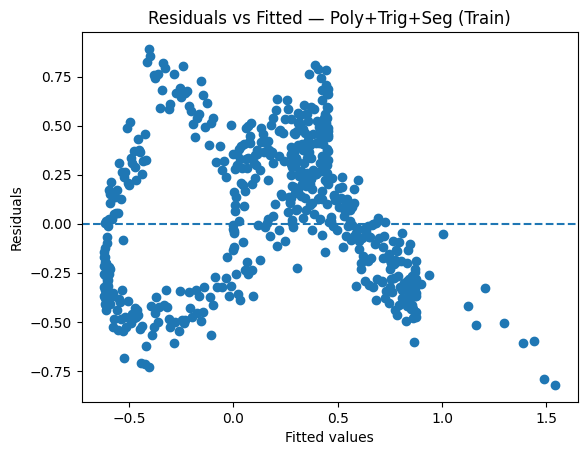

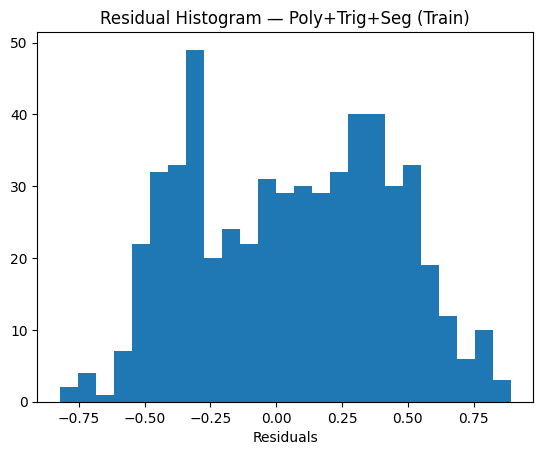

<Figure size 640x480 with 0 Axes>

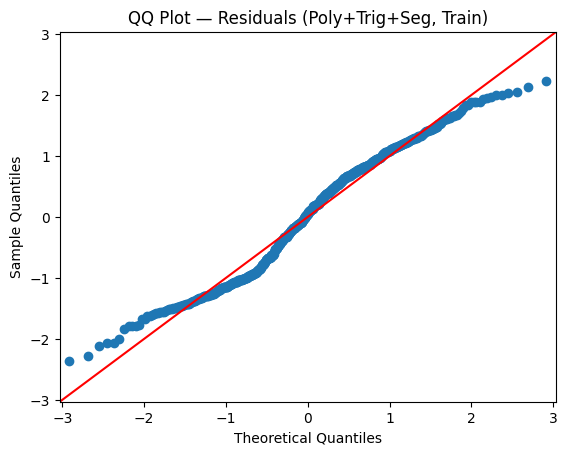

In [14]:
# PURPOSE:
# - Plot residual diagnostics on TRAIN:
#   * Residuals vs Fitted (random scatter around 0 is good)
#   * Histogram of residuals (bell-shaped if ~Normal)
#   * QQ plot (points near 45° line if ~Normal errors)

resid = best_ols.resid
fitted = best_ols.fittedvalues

plt.figure()
plt.scatter(fitted, resid)
plt.axhline(0, linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Fitted — {best_name} (Train)")
plt.show()

plt.figure()
plt.hist(resid, bins=25)
plt.xlabel("Residuals")
plt.title(f"Residual Histogram — {best_name} (Train)")
plt.show()

plt.figure()
sm.qqplot(resid, line='45', fit=True)
plt.title(f"QQ Plot — Residuals ({best_name}, Train)")
plt.show()

## Cell 10 — Full OLS summary for the winner (Train)

In [15]:
# PURPOSE:
# - Display full statsmodels OLS summary for the winning design.

print(best_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     187.8
Date:                Sat, 11 Oct 2025   Prob (F-statistic):          1.09e-101
Time:                        09:27:35   Log-Likelihood:                -249.33
No. Observations:                 560   AIC:                             508.7
Df Residuals:                     555   BIC:                             530.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.674e-08    4.7e-09     18.463      0.0

## Cell 11 — Visual check: Actual vs Predicted (Test) for all designs

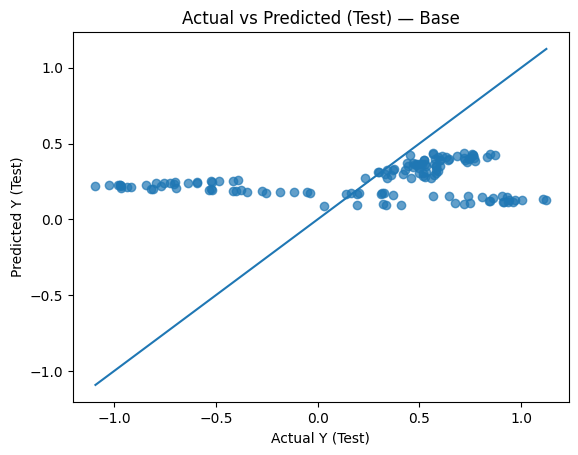

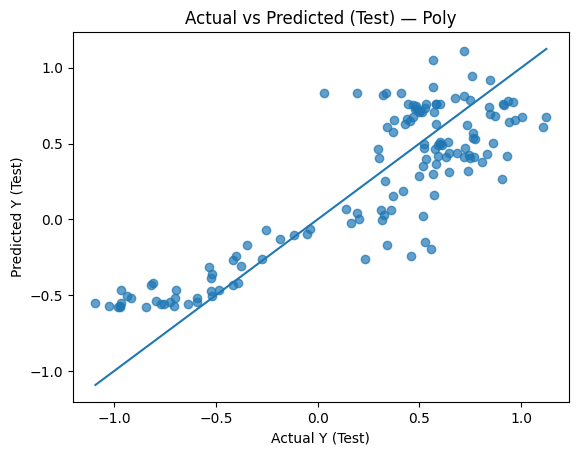

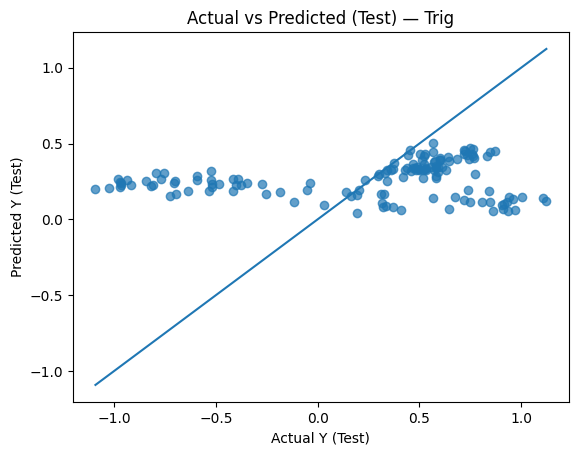

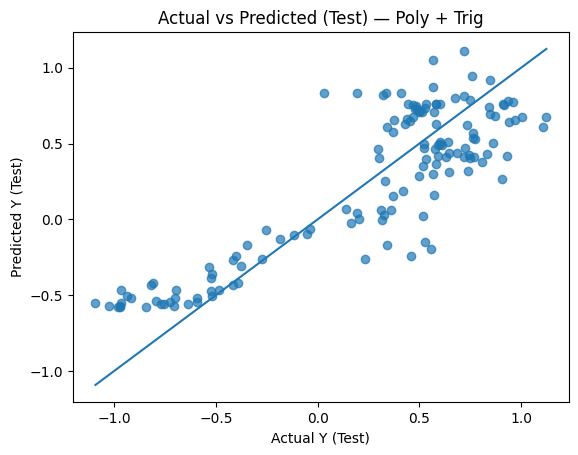

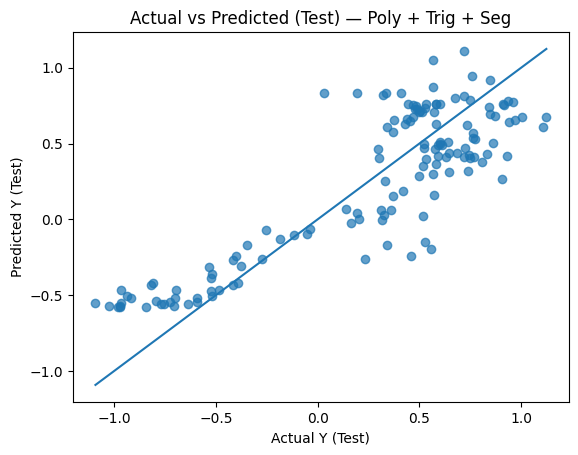

In [16]:
# PURPOSE:
# - Plot Actual vs Predicted (Test) for each sklearn model/design.

def plot_actual_pred(name, data, model):
    X_tr, X_te, y_tr, y_te, yhat_tr, yhat_te = data
    plt.figure()
    plt.scatter(y_te, yhat_te, alpha=0.7)
    lims = [min(y_te.min(), yhat_te.min()), max(y_te.max(), yhat_te.max())]
    plt.plot(lims, lims)
    plt.xlabel("Actual Y (Test)")
    plt.ylabel("Predicted Y (Test)")
    plt.title(f"Actual vs Predicted (Test) — {name}")
    plt.show()

plot_actual_pred("Base",            base_data,  sk_base_model)
plot_actual_pred("Poly",            poly_data,  sk_poly_model)
plot_actual_pred("Trig",            trig_data,  sk_trig_model)
plot_actual_pred("Poly + Trig",     pt_data,    sk_pt_model)
plot_actual_pred("Poly + Trig + Seg", pts_data, sk_pts_model)

## Cell 12 — Takeaways / conclusions

In [17]:
# PURPOSE:
# - Summarize Test metrics and provide instructor notes for discussion.

def test_metrics(data):
    X_tr, X_te, y_tr, y_te, yhat_tr, yhat_te = data
    r2_te = r2_score(y_te, yhat_te)
    rmse_te = np.sqrt(mean_squared_error(y_te, yhat_te))
    return r2_te, rmse_te

rows = []
for name, data in zip(
    ["Base","Poly","Trig","Poly+Trig","Poly+Trig+Seg"],
    [base_data, poly_data, trig_data, pt_data, pts_data]
):
    r2te, rmsete = test_metrics(data)
    rows.append([name, r2te, rmsete])

summary_test = pd.DataFrame(rows, columns=["Model","Test_R2","Test_RMSE"]).sort_values(
    ["Test_R2","Test_RMSE"], ascending=[False, True]
).reset_index(drop=True)

print("=== Summary: Test-set metrics (sklearn) ===")
print(summary_test)

print("\n=== Instructor Notes / Conclusions ===")
print("- Plain linear model on raw X struggles with a sine-like, non-linear pattern.")
print("- Adding polynomial terms improves fit; adding trigonometric (sin/cos harmonics) often improves further.")
print("- If the dataset has piecewise behavior (segments), simple segment indicators can help capture level shifts.")
print("- From the OLS comparison (Adj R² & AIC), the winner was:", best_name)
print("- Always inspect residuals for randomness and normality; avoid obvious patterns.")
print("- Prefer a parsimonious model (fewest features) that achieves strong Test metrics and passes diagnostics.")

=== Summary: Test-set metrics (sklearn) ===
           Model   Test_R2  Test_RMSE
0  Poly+Trig+Seg  0.746565   0.298628
1           Poly  0.746565   0.298628
2      Poly+Trig  0.746565   0.298628
3           Base  0.052918   0.577286
4           Trig  0.024999   0.585733

=== Instructor Notes / Conclusions ===
- Plain linear model on raw X struggles with a sine-like, non-linear pattern.
- Adding polynomial terms improves fit; adding trigonometric (sin/cos harmonics) often improves further.
- If the dataset has piecewise behavior (segments), simple segment indicators can help capture level shifts.
- From the OLS comparison (Adj R² & AIC), the winner was: Poly+Trig+Seg
- Always inspect residuals for randomness and normality; avoid obvious patterns.
- Prefer a parsimonious model (fewest features) that achieves strong Test metrics and passes diagnostics.
